In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt 
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the PyDrive client

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Getting File using ID (got ID via shareable link of file) 

In [0]:
downloaded = drive.CreateFile({'id':"17GkMR6sWo03c_JaCKbDOOTYCDfaF6sPn"})  
downloaded.GetContentFile('data.csv') 

In [0]:
data = pd.read_csv('data.csv', encoding = 'unicode_escape')

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
pd.to_datetime(data.InvoiceDate.max())-pd.to_datetime(data.InvoiceDate.min()) 

Timedelta('241 days 23:48:00')

Checking for duplicates now and will remove those duplicates


In [12]:
data.duplicated().sum()

5268

In [0]:
data.drop_duplicates(inplace = True)

In [14]:
data.duplicated().sum()

0

Now dropping customers and descriptions missing fields from the dataset

In [0]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.Description.isnull()==False)].copy()

In [16]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [18]:
data.min()

InvoiceNo                              536365
StockCode                               10002
Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                               -80995
InvoiceDate                   1/10/2011 10:32
UnitPrice                                   0
CustomerID                              12346
Country                             Australia
dtype: object

In [19]:
data.max()

InvoiceNo                               C581569
StockCode                                  POST
Description    ZINC WIRE SWEETHEART LETTER TRAY
Quantity                                  80995
InvoiceDate                       9/9/2011 9:52
UnitPrice                                 38970
CustomerID                                18287
Country                             Unspecified
dtype: object

In [20]:
data.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

Now main object is to remove outliers that is negative and 0 quantity is not at all possible so now we have to remove that and also the returns orders are to be seperated as the prediciton is for orders placements and not the returs.

In [21]:
data['Quantity'][data['Quantity'] < 0].nunique()

134

Here we see the values of quantity which are less than 0 and there are no quantity which is values as 0.

In [0]:
data = data[data['Quantity'] > 0]

In [23]:
data.min()

InvoiceNo                              536365
StockCode                               10002
Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                                    1
InvoiceDate                   1/10/2011 10:32
UnitPrice                                   0
CustomerID                              12346
Country                             Australia
dtype: object

So now the Quantity outliers have been removed now we are left with the return orders

In [24]:
data.Quantity.describe()

count    392732.000000
mean         13.153718
std         181.588420
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [25]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [26]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


Sales Column created


In [27]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
data[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [28]:
data[data['InvoiceNo'].str.startswith('c')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales


In [29]:
data['Sales'].describe()

count    392732.000000
mean         22.629195
std         311.083465
min           0.000000
25%           4.950000
50%          12.390000
75%          19.800000
max      168469.600000
Name: Sales, dtype: float64

In [30]:
print('Duplicate invoice = ',data['InvoiceNo'].duplicated().sum())
print('Unique invoce = ',data['InvoiceNo'].nunique())

Duplicate invoice =  374196
Unique invoce =  18536


In [31]:
print('Unique Values :- ')
print('Country : ',data['Country'].nunique())
print('Quantity : ',data['Quantity'].nunique())
print('Items : ',data['Description'].nunique())

Unique Values :- 
Country :  37
Quantity :  302
Items :  3877


In [32]:
print("Most Occured :- ")
print('Country = ', data['Country'].mode()[0])
print('Description = ', data['Description'].mode()[0])

Most Occured :- 
Country =  United Kingdom
Description =  WHITE HANGING HEART T-LIGHT HOLDER


In [33]:
data.groupby(['Country']).sum().head()

,Quantity,UnitPrice,CustomerID,Sales
Country,,,,
Australia,84199,3605.75,14746097.0,138453.81
Austria,4881,1693.90,4982601.0,10198.68
Bahrain,260,78.95,210027.0,548.40
Belgium,23237,7372.85,25246701.0,41196.34
Brazil,356,142.60,408608.0,1143.60


In [0]:
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format='%m/%d/%Y %H:%M')

 New Columns inserted related to Date & Time

In [0]:
data.insert(loc=4, column='Day', value=data.InvoiceDate.dt.day)
data.insert( loc = 5,column='Month', value=data.InvoiceDate.dt.month)
data.insert( loc = 6,column='Year', value=data.InvoiceDate.dt.year)
data.insert( loc = 7,column='WeekDay', value=data.InvoiceDate.dt.weekday)
data.insert( loc = 8,column='Hour', value=data.InvoiceDate.dt.hour)
data.insert( loc = 9,column='Minute', value=data.InvoiceDate.dt.minute)
data.insert( loc = 10,column='Date', value=data.InvoiceDate.dt.date)


In [36]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,Day,Month,Year,WeekDay,Hour,Minute,Date,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


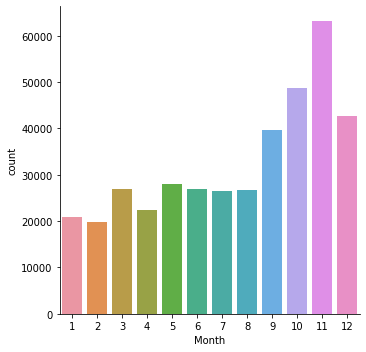

In [37]:
sns.catplot(data=data, x= 'Month', kind = 'count')

Text(0.5, 1.0, 'Month wise Sales ')

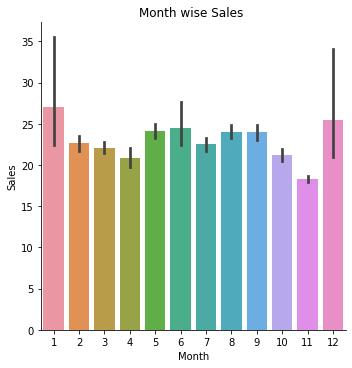

In [38]:
sns.catplot(data=data, x= 'Month', y='Sales', kind = 'bar')
plt.title('Month wise Sales ')

Text(0.5, 1.0, 'Sales vs WeekDay ')

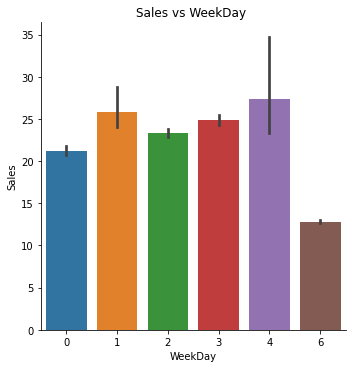

In [39]:
sns.catplot(data=data, x= 'WeekDay', y='Sales', kind = 'bar')
plt.title('Sales vs WeekDay ')
# Monday = 0 to Sunday = 6

In [40]:
data.groupby(['WeekDay']).sum()

,Quantity,Day,Month,Year,Hour,Minute,UnitPrice,CustomerID,Sales
WeekDay,,,,,,,,,
0,766919,993088,492697,129176624,814038,1960096,218722.441,9.811911e+08,1363604.401
1,1005772,990912,484248,132214129,821915,1998245,203212.781,1.004222e+09,1697733.801
2,960128,1032392,513903,136829173,855164,2096939,210488.470,1.041206e+09,1584283.830
3,1150224,1175117,602436,159386178,1051033,2411022,255621.020,1.209629e+09,1973015.730
4,821859,756755,411603,109055378,660933,1657546,168860.421,8.221724e+08,1483080.811
6,460984,960252,480636,123096897,793088,1817657,170616.251,9.455622e+08,785490.321


In [41]:
data['InvoiceNo'].value_counts().head(10)

576339    542
579196    533
580727    529
578270    442
573576    435
567656    421
567183    392
575607    377
571441    364
570488    353
Name: InvoiceNo, dtype: int64

In [42]:
data['CustomerID'].value_counts().head(10)

17841.0    7676
14911.0    5672
14096.0    5111
12748.0    4413
14606.0    2677
15311.0    2366
14646.0    2080
13089.0    1814
13263.0    1667
14298.0    1637
Name: CustomerID, dtype: int64

In [43]:
data['StockCode'].value_counts().head()

85123A    2023
22423     1714
85099B    1615
84879     1395
47566     1390
Name: StockCode, dtype: int64

Text(0.5, 1.0, 'Order Count Abroad (Outside UK) ')

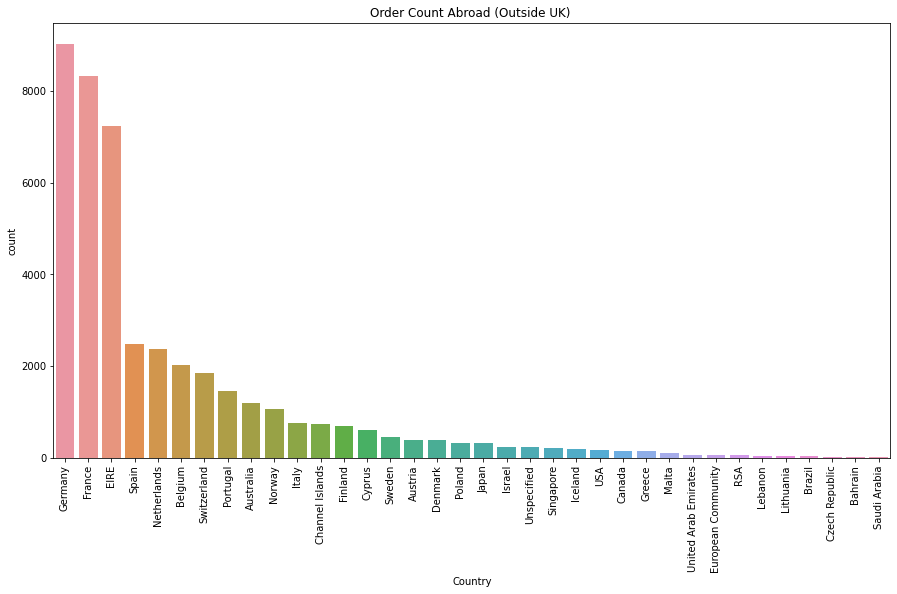

In [44]:
plt.figure(figsize=(15,8))
#sns.countplot(data['Country'])
sns.countplot(data[data['Country'] != 'United Kingdom']['Country'] , order = data[data['Country'] != 'United Kingdom']['Country'].value_counts().index)

plt.xticks(rotation=90)
plt.title('Order Count Abroad (Outside UK) ')

In [0]:
descrip_count =  data.Description.value_counts().sort_values(ascending=False).iloc[0:15]

Text(0.5, 1.0, 'Top 10 Products ')

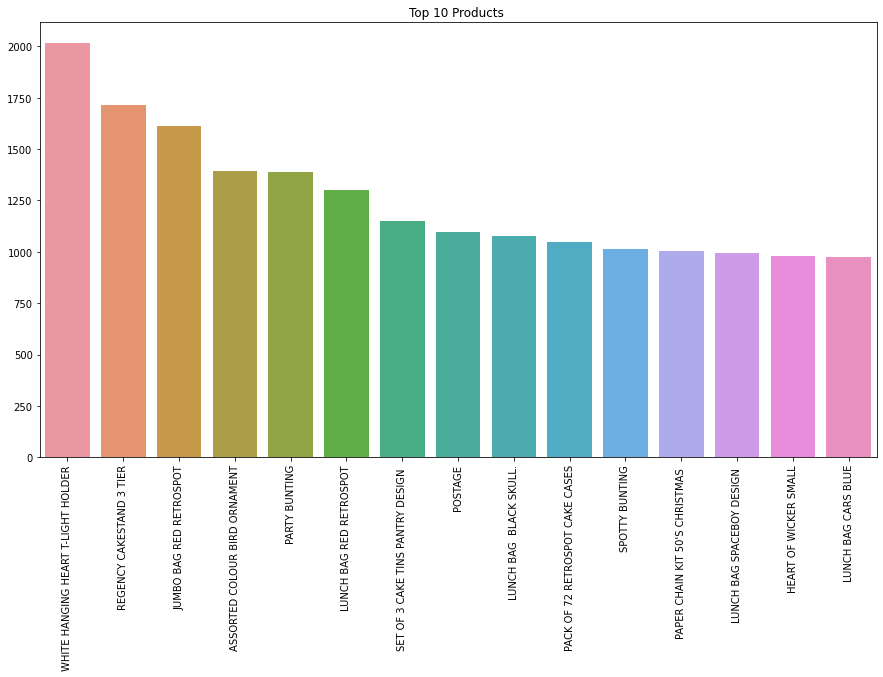

In [46]:
plt.figure(figsize=(15,8))
sns.barplot(y = descrip_count.values, x=descrip_count.index )
plt.xticks(rotation=90)
plt.title('Top 10 Products ')

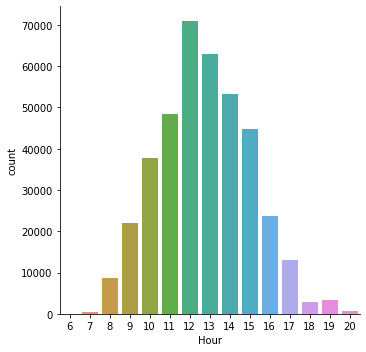

In [47]:
sns.catplot(data=data, x = 'Hour', kind = 'count')



---


EDA Result:


1.   Max Orders in month (Sep to Dec)
2.   WeekDay wise sales increases till Thursday then decreses 
3.   No Transaction on Saturday
4.   Maximum Sale in UK (as it is UK based company)
5.   Abroad Max Sales in Germany, France, etc. (refer above graph)
6.   Top Products (refer above graph)  
7.   Orders Increases till 12 then decreases




---








---

Modelling

In [48]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [0]:
now = dt.date(2011,12,9) 

In [50]:
new_df = data.groupby(by='CustomerID', as_index=False)['Date'].max()
new_df.columns = ['CustomerID', 'LastPurchaseDate']
new_df[:5]

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [51]:
new_df['Recency'] =  new_df['LastPurchaseDate'].apply(lambda x : (now-x).days)
new_df.drop('LastPurchaseDate',axis = 1, inplace = True)
new_df[:5]

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [52]:
new_df2 = data.groupby(by = 'CustomerID', as_index=False)['InvoiceNo'].count()
new_df2.columns = ['CustomerID','Frequency']
new_df2[:4]

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73


In [53]:
new_df3 = data.groupby(by='CustomerID',as_index=False).agg({'Sales': 'sum'})
new_df3.columns = ['CustomerID','Monetary']
new_df3[:4]

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55


In [54]:
temp = new_df.merge(new_df2, on = 'CustomerID')
rfm_df = temp.merge(new_df3, on = 'CustomerID')
rfm_df.set_index('CustomerID',inplace = True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [55]:
rfm_df['R_quartile'] = pd.qcut(rfm_df['Recency'], 4, ['1','2','3','4'])
rfm_df['F_quartile'] = pd.qcut(rfm_df['Frequency'], 4, ['4','3','2','1'])
rfm_df['M_quartile'] = pd.qcut(rfm_df['Monetary'], 4, ['4','3','2','1'])
rfm_df.head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,18,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3


In [56]:
rfm_df['RFM_Score'] = rfm_df.R_quartile.astype(str)+ rfm_df.F_quartile.astype(str) + rfm_df.M_quartile.astype(str)
rfm_df.head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,31,1797.24,3,3,1,331
12349.0,18,73,1757.55,2,2,1,221
12350.0,310,17,334.40,4,4,3,443


Score best : 1 worst : 4

Top/Best Customers

In [57]:
rfm_df[rfm_df['RFM_Score']==str(111)].head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12347.0,2,182,4310.00,1,1,1,111
12362.0,3,266,5226.23,1,1,1,111
12388.0,15,100,2780.66,1,1,1,111
12417.0,3,192,3649.10,1,1,1,111
12423.0,0,125,1859.31,1,1,1,111


Loyal Customers

In [58]:
rfm_df[rfm_df['F_quartile']=='1'].head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12347.0,2,182,4310.00,1,1,1,111
12357.0,33,131,6207.67,2,1,1,211
12359.0,57,245,6310.03,3,1,1,311
12360.0,52,129,2662.06,3,1,1,311
12362.0,3,266,5226.23,1,1,1,111


Customer who spent most

In [59]:
rfm_df[rfm_df['M_quartile']=='1'].head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,31,1797.24,3,3,1,331
12349.0,18,73,1757.55,2,2,1,221
12352.0,36,85,2506.04,2,2,1,221


Lost Customers

In [60]:
rfm_df[rfm_df['RFM_Score']==str(444)].head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12353.0,204,4,89.00,4,4,4,444
12361.0,287,10,189.90,4,4,4,444
12401.0,303,5,84.30,4,4,4,444
12402.0,323,11,225.60,4,4,4,444
12441.0,366,11,173.55,4,4,4,444


In [61]:
rfm_df[rfm_df['RFM_Score']==str(111)].shape

(443, 7)

In [0]:
temp = rfm_df[rfm_df['RFM_Score']==str(111)][['Recency','Frequency','Monetary']]

In [63]:
temp.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,4310.00
12362.0,3,266,5226.23
12388.0,15,100,2780.66
12417.0,3,192,3649.10
12423.0,0,125,1859.31


In [0]:
# for i in range(10):
kmeans = KMeans(n_clusters=3, random_state=0).fit(temp)

In [0]:
temp['predicted'] = kmeans.labels_

In [0]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=["x1", "x2","x3"])

In [0]:
colors = ["red", "green", "blue"]
temp['color'] = temp['predicted'].map(lambda p: colors[p])

In [68]:
temp.tail()

,Recency,Frequency,Monetary,predicted,color
CustomerID,,,,,
18229.0,11,164,7276.90,0,red
18241.0,9,104,2073.09,0,red
18245.0,7,175,2567.06,0,red
18272.0,2,166,3078.58,0,red
18283.0,3,721,2045.53,0,red


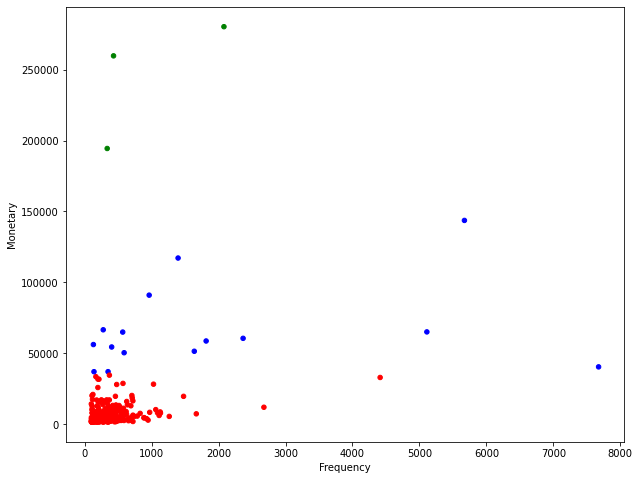

In [69]:
ax = temp.plot(    
    kind="scatter", 
    x="Frequency", y="Monetary",
    figsize=(10,8),
    c = temp['color']
)

Word Cloud for Best Customer

In [70]:
temp2 = rfm_df[rfm_df['RFM_Score']==str(111)]
temp2.head()

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
CustomerID,,,,,,,
12347.0,2,182,4310.00,1,1,1,111
12362.0,3,266,5226.23,1,1,1,111
12388.0,15,100,2780.66,1,1,1,111
12417.0,3,192,3649.10,1,1,1,111
12423.0,0,125,1859.31,1,1,1,111


In [0]:
temp3 = pd.DataFrame()

In [72]:
temp2.reset_index(level=0, inplace=True)
temp2.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
0,12347.0,2,182,4310.00,1,1,1,111
1,12362.0,3,266,5226.23,1,1,1,111
2,12388.0,15,100,2780.66,1,1,1,111
3,12417.0,3,192,3649.10,1,1,1,111
4,12423.0,0,125,1859.31,1,1,1,111


In [73]:
print(data.shape)
print(temp2.shape)

(392732, 16)
(443, 8)


Right Join on temp2 and data 


In [0]:
temp3 =  pd.merge(temp2,data.drop_duplicates(),on='CustomerID',how='right')

In [75]:
temp3.shape

(392732, 23)

In [76]:
temp3['CustomerID'].nunique()

4339

In [77]:
temp2['CustomerID'].nunique()

443

In [78]:
data['CustomerID'].nunique()

4339

In [79]:
temp3.dropna(inplace=True)
temp3['CustomerID'].nunique()

443

In [80]:
temp3.shape

(164374, 23)

In [81]:
temp3.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score,InvoiceNo,StockCode,Description,Quantity,Day,Month,Year,WeekDay,Hour,Minute,Date,InvoiceDate,UnitPrice,Country,Sales
0,12347.0,2.0,182.0,4310.0,1,1,1,111,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,7,12,2010,1,14,57,2010-12-07,2010-12-07 14:57:00,2.10,Iceland,25.2
1,12347.0,2.0,182.0,4310.0,1,1,1,111,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,7,12,2010,1,14,57,2010-12-07,2010-12-07 14:57:00,4.25,Iceland,17.0
2,12347.0,2.0,182.0,4310.0,1,1,1,111,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,7,12,2010,1,14,57,2010-12-07,2010-12-07 14:57:00,3.25,Iceland,39.0
3,12347.0,2.0,182.0,4310.0,1,1,1,111,537626,22492,MINI PAINT SET VINTAGE,36,7,12,2010,1,14,57,2010-12-07,2010-12-07 14:57:00,0.65,Iceland,23.4
4,12347.0,2.0,182.0,4310.0,1,1,1,111,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,7,12,2010,1,14,57,2010-12-07,2010-12-07 14:57:00,1.25,Iceland,15.0


In [82]:
#Fetch wordcount for each Description
temp3['word_count'] = temp3['Description'].apply(lambda x: len(str(x).split(" ")))
temp3[['Description','word_count']].head()

,Description,word_count
0,BLACK CANDELABRA T-LIGHT HOLDER,4
1,AIRLINE BAG VINTAGE JET SET BROWN,6
2,COLOUR GLASS. STAR T-LIGHT HOLDER,5
3,MINI PAINT SET VINTAGE,5
4,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,5


temp4 contains description of products bought by best customers, this list of description will be used for wordcloud

In [0]:
temp4 = temp3[['Description','word_count']]

In [84]:
temp4.head()

,Description,word_count
0,BLACK CANDELABRA T-LIGHT HOLDER,4
1,AIRLINE BAG VINTAGE JET SET BROWN,6
2,COLOUR GLASS. STAR T-LIGHT HOLDER,5
3,MINI PAINT SET VINTAGE,5
4,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,5


Word Count Summary

In [85]:
temp4.word_count.describe()

count    164374.000000
mean          4.645114
std           1.185199
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           9.000000
Name: word_count, dtype: float64

In [86]:
#Identify common words
freq = pd.Series(' '.join(temp4['Description']).split()).value_counts()[:20]
freq

BAG          18218
OF           16413
SET          16089
RED          14337
RETROSPOT    11726
HEART        11494
VINTAGE      10571
DESIGN       10128
PINK          8662
JUMBO         7507
BOX           7459
CHRISTMAS     7356
LUNCH         7309
METAL         6677
WHITE         6668
CAKE          6490
BLUE          5939
SIGN          5617
3             5585
HANGING       5093
dtype: int64

In [87]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(temp4 ['Description']).split()).value_counts()[-20:]
freq1


W/KNIF             1
CONGRATULATIONS    1
NEST,              1
PAGE               1
ARTIIFCIAL         1
BUM                1
PERIDOT            1
TROPEZ             1
60x40cm            1
ART,ONLY           1
BLACK+WHITE        1
OLD                1
PACKING            1
A5                 1
W/SUCKER           1
AQUA               1
MARSHMALLOW        1
MUMMY              1
DIAMON             1
TRELLISTRIPLE      1
dtype: int64

In [88]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
stop_words = set(stopwords.words("english"))
new_words = ['RED','PINK', 'BLUE', 'OF', 'BROWN',"BLACK"]
stop_words = stop_words.union(new_words)


In [90]:
for i in new_words:
  if i in stop_words:
    print(i)


RED
PINK
BLUE
OF
BROWN
BLACK


In [0]:
corpus = []
for i in range(0, 164373):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', temp4['Description'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if word not in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [92]:
corpus[:10]

['black candelabra light holder',
 'airline bag vintage jet set brown',
 'colour glass star light holder',
 'mini paint set vintage',
 'clear drawer knob acrylic edwardian',
 'pink drawer knob acrylic edwardian',
 'green drawer knob acrylic edwardian',
 'red drawer knob acrylic edwardian',
 'purple drawerknob acrylic edwardian',
 'blue drawer knob acrylic edwardian']

In [0]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
wordcloud = WordCloud(    #background_color='white',
                          stopwords=stop_words,
                          max_words=200,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))

Text(0.5, 1.0, "Word Cloud for Best Customer's Products")

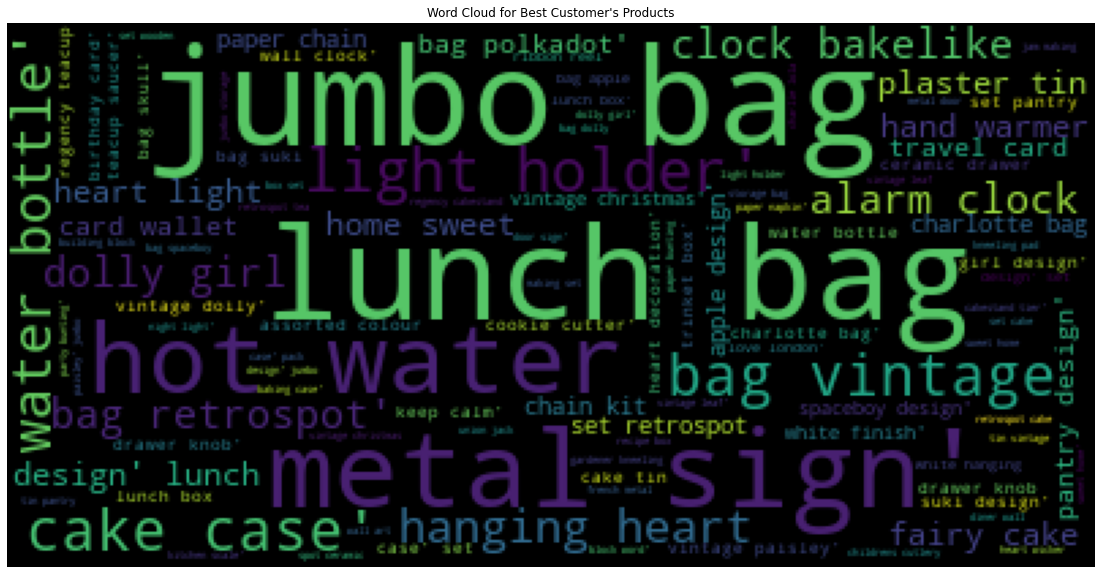

In [95]:
plt.figure(figsize=(25,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud for Best Customer\'s Products')

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['black', 'blue', 'brown', 'pink', 'red'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [97]:
list(cv.vocabulary_.keys())[:20]

['black',
 'candelabra',
 'light',
 'holder',
 'black candelabra',
 'candelabra light',
 'light holder',
 'black candelabra light',
 'candelabra light holder',
 'airline',
 'bag',
 'vintage',
 'jet',
 'set',
 'brown',
 'airline bag',
 'bag vintage',
 'vintage jet',
 'jet set',
 'set brown']

In [0]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

Getting top 20 words in top_df dataframe

In [99]:
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df[:10]

,Word,Freq
0,set,18800
1,bag,18309
2,red,14636
3,heart,13169
4,retrospot,11726
5,vintage,10571
6,design,10296
7,pink,8860
8,box,8427
9,jumbo,7506


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

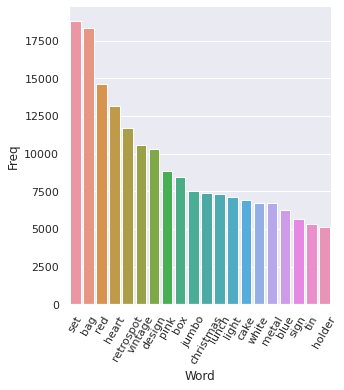

In [100]:
sns.set(rc={'figure.figsize':(13,8)})
sns.catplot(data=top_df,x='Word',y='Freq',kind='bar')
plt.xticks(rotation = 60)